In [106]:
import numpy as np
import pandas as pd
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [107]:
os.listdir(), os.listdir('churn_dataset/')

(['Churn_modeling.ipynb', '.ipynb_checkpoints', 'churn_dataset'],
 ['Churn_Modelling.csv'])

In [108]:
data = pd.read_csv('./churn_dataset/Churn_Modelling.csv')

In [109]:
data.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9188,9189,15778192,Nkemdilim,628,Spain,Male,28,4,0.00,2,1,1,176750.81,0
9670,9671,15651336,Chidiebere,756,France,Female,32,4,0.00,2,1,0,147040.25,0
1879,1880,15768095,Yeh,579,France,Male,31,9,0.00,1,0,1,139048.00,0
9844,9845,15588456,Hsieh,658,France,Female,40,5,143566.12,1,1,1,189607.71,0
473,474,15681705,Fanucci,785,France,Male,28,8,0.00,2,1,0,77231.27,0


In [110]:
data.shape

(10000, 14)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [112]:
# Surname does not have to do anything with response
df = data.drop(['Surname','RowNumber','CustomerId'],axis = 1)

In [113]:
# setting categorical and numerical columns
cat_cols = df.select_dtypes('object')
num_cols = df.select_dtypes('number')

## Categorical Encoding

In [114]:
# Encoding categorical values
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
encoder_df = pd.DataFrame(ohe.fit_transform(df[['Geography','Gender']]))
df = df.join(encoder_df)
df.drop(['Geography', 'Gender'], axis = 1, inplace = True)

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Exited           10000 non-null  int64  
 9   0                10000 non-null  float64
 10  1                10000 non-null  float64
 11  2                10000 non-null  float64
 12  3                10000 non-null  float64
 13  4                10000 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 1.1 MB


## Outlier removal

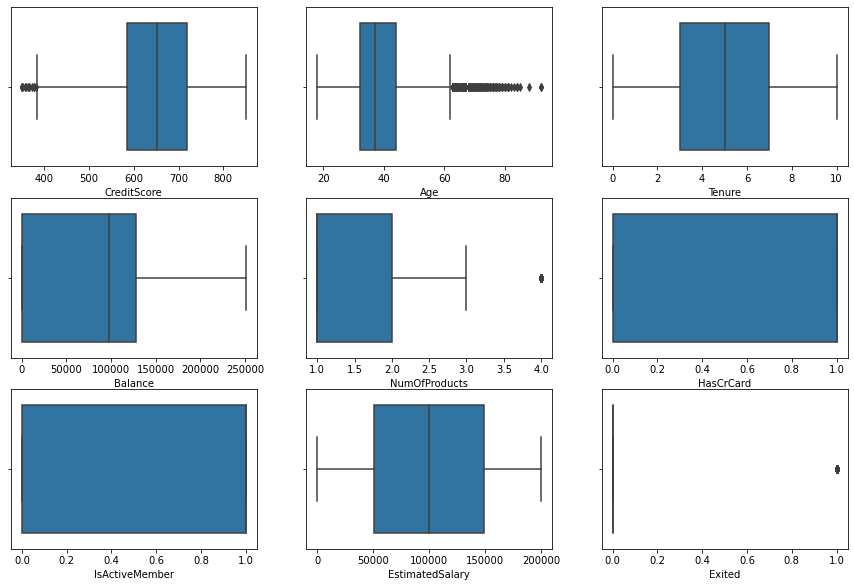

In [116]:
# Looking for outliers
plt.figure(figsize=(15,17))
i = 1
for col in num_cols:
    plt.subplot(5,3,i)
    sns.boxplot(data=df, x = col, hue = 'Exited')
    i += 1

In [117]:

# Removing the Outliers
from sklearn.covariance import EllipticEnvelope
import warnings
warnings.filterwarnings('ignore')

out_rem = EllipticEnvelope(contamination=.1,random_state=33)
mask = out_rem.fit_predict(df)

In [118]:
mask = np.where(mask != 1,True, False)
df['isoutlier'] = mask

In [119]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,0,1,2,3,4,isoutlier
0,619,42,2,0.00,1,1,1,101348.88,1,1.0,0.0,0.0,1.0,0.0,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0.0,0.0,1.0,1.0,0.0,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1.0,0.0,0.0,1.0,0.0,True
3,699,39,1,0.00,2,0,0,93826.63,0,1.0,0.0,0.0,1.0,0.0,False
4,850,43,2,125510.82,1,1,1,79084.10,0,0.0,0.0,1.0,1.0,0.0,False


In [120]:
df_no_outlier = df[df.isoutlier == False]
df_no_outlier.drop('isoutlier',axis = 1, inplace=True)

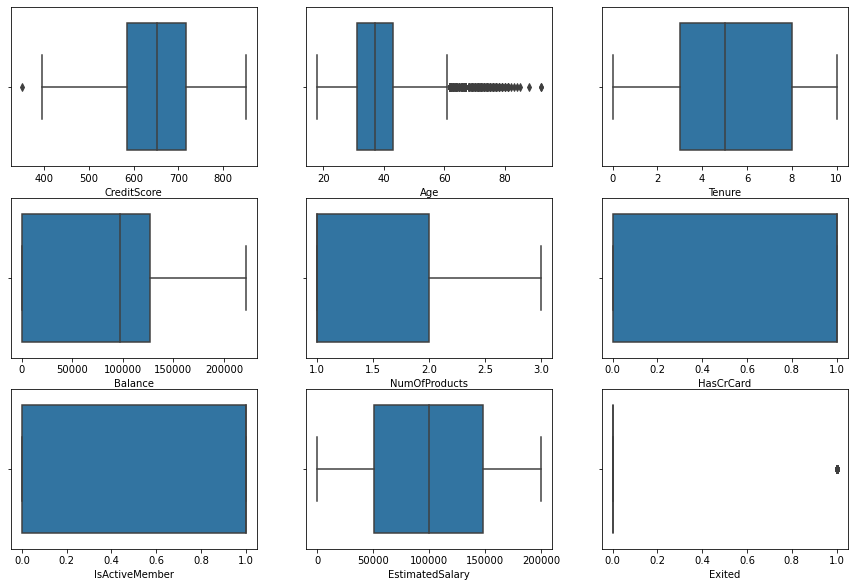

In [121]:
# Looking for outliers again to check the difference
plt.figure(figsize=(15,17))
i = 1
for col in num_cols:
    plt.subplot(5,3,i)
    sns.boxplot(data=df_no_outlier, x = col, hue = 'Exited')
    i += 1

## Setting response and feature dataframe separate

In [122]:
X = df_no_outlier.drop('Exited', axis = 1)
y = df_no_outlier.Exited

## Checking for class imbalance

In [123]:
df_no_outlier.Exited.value_counts()

0    7963
1    1037
Name: Exited, dtype: int64

In [126]:
# import library
from imblearn.over_sampling import SMOTE

smote = SMOTE()


# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)


print(f'Original data: X = {X.shape}, {y.shape}')
print(y.value_counts())
print(f'Oversampled data: X = {x_smote.shape}, {y_smote.shape}')
print(y_smote.value_counts())


Original data: X = (9000, 13), (9000,)
0    7963
1    1037
Name: Exited, dtype: int64
Oversampled data: X = (15926, 13), (15926,)
1    7963
0    7963
Name: Exited, dtype: int64


## Scaling / Normalization

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [127]:
scaler = MinMaxScaler()
x_smote = scaler.fit_transform(x_smote)
x_smote[:3,:]

array([[0.53707415, 0.32432432, 0.2       , 0.        , 0.        ,
        1.        , 1.        , 0.50673489, 1.        , 0.        ,
        0.        , 1.        , 0.        ],
       [0.51503006, 0.31081081, 0.1       , 0.37830904, 0.        ,
        0.        , 1.        , 0.56270874, 0.        , 0.        ,
        1.        , 1.        , 0.        ],
       [0.69739479, 0.28378378, 0.1       , 0.        , 0.5       ,
        0.        , 0.        , 0.46912005, 1.        , 0.        ,
        0.        , 1.        , 0.        ]])

## Creating train and test set

In [20]:
from sklearn.model_selection import train_test_split

In [128]:
xtrain, xtest, ytrain, ytest = train_test_split(x_smote, y_smote, test_size=.1, random_state= 33)

In [129]:
xtrain.shape

(14333, 13)

## Creating a DL model

In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten

In [131]:
Model = keras.models.Sequential()

In [132]:
Model.add(Dense( units = 20, activation = 'relu'))
Model.add(Dropout(.4))

Model.add(Dense( units = 15, activation= 'relu'))
Model.add(Dropout(.3))

Model.add(Dense( units = 10, activation= 'relu'))
Model.add(Dropout(.3))

Model.add(Dense(units=1, activation='sigmoid'))

In [133]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [134]:
Model.compile(optimizer='Adamax', loss='binary_crossentropy', metrics = METRICS)

In [135]:
model_history = Model.fit(xtrain, ytrain, batch_size= 128, epochs= 100, validation_split=.1)

Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 0.7265 - tp: 1580.1471 - fp: 1507.0000 - tn: 1790.9216 - fn: 1712.1078 - accuracy: 0.5080 - precision: 0.5050 - recall: 0.4773 - auc: 0.5059 - prc: 0.4952 - val_loss: 0.6655 - val_tp: 472.0000 - val_fp: 165.0000 - val_tn: 545.0000 - val_fn: 252.0000 - val_accuracy: 0.7092 - val_precision: 0.7410 - val_recall: 0.6519 - val_auc: 0.7702 - val_prc: 0.7259
Epoch 2/100
101/101 [==============================] - 0s 1ms/step - loss: 0.6773 - tp: 1767.6667 - fp: 1335.0686 - tn: 1996.7451 - fn: 1490.6961 - accuracy: 0.5666 - precision: 0.5635 - recall: 0.5444 - auc: 0.6002 - prc: 0.5648 - val_loss: 0.6182 - val_tp: 502.0000 - val_fp: 146.0000 - val_tn: 564.0000 - val_fn: 222.0000 - val_accuracy: 0.7434 - val_precision: 0.7747 - val_recall: 0.6934 - val_auc: 0.8545 - val_prc: 0.8199
Epoch 3/100
101/101 [==============================] - 0s 1ms/step - loss: 0.6389 - tp: 2121.6569 - fp: 1175.4804 - tn: 2120.5392 - fn: 1172.5

101/101 [==============================] - 0s 2ms/step - loss: 0.3500 - tp: 2986.7255 - fp: 596.6275 - tn: 2707.6569 - fn: 299.1667 - accuracy: 0.8631 - precision: 0.8349 - recall: 0.9063 - auc: 0.9222 - prc: 0.8973 - val_loss: 0.2967 - val_tp: 664.0000 - val_fp: 113.0000 - val_tn: 597.0000 - val_fn: 60.0000 - val_accuracy: 0.8794 - val_precision: 0.8546 - val_recall: 0.9171 - val_auc: 0.9410 - val_prc: 0.9184
Epoch 21/100
101/101 [==============================] - 0s 2ms/step - loss: 0.3485 - tp: 2982.6863 - fp: 622.1078 - tn: 2685.8431 - fn: 299.5392 - accuracy: 0.8600 - precision: 0.8258 - recall: 0.9126 - auc: 0.9216 - prc: 0.8993 - val_loss: 0.2945 - val_tp: 667.0000 - val_fp: 118.0000 - val_tn: 592.0000 - val_fn: 57.0000 - val_accuracy: 0.8780 - val_precision: 0.8497 - val_recall: 0.9213 - val_auc: 0.9417 - val_prc: 0.9197
Epoch 22/100
101/101 [==============================] - 0s 2ms/step - loss: 0.3458 - tp: 3012.2549 - fp: 595.7647 - tn: 2691.6176 - fn: 290.5392 - accuracy: 0.

101/101 [==============================] - 0s 1ms/step - loss: 0.3169 - tp: 3028.1373 - fp: 526.4804 - tn: 2753.7941 - fn: 281.7647 - accuracy: 0.8792 - precision: 0.8558 - recall: 0.9143 - auc: 0.9365 - prc: 0.9211 - val_loss: 0.2800 - val_tp: 663.0000 - val_fp: 97.0000 - val_tn: 613.0000 - val_fn: 61.0000 - val_accuracy: 0.8898 - val_precision: 0.8724 - val_recall: 0.9157 - val_auc: 0.9474 - val_prc: 0.9201
Epoch 40/100
101/101 [==============================] - 0s 1ms/step - loss: 0.3155 - tp: 3033.7941 - fp: 498.9314 - tn: 2781.7255 - fn: 275.7255 - accuracy: 0.8825 - precision: 0.8600 - recall: 0.9159 - auc: 0.9373 - prc: 0.9205 - val_loss: 0.2789 - val_tp: 666.0000 - val_fp: 98.0000 - val_tn: 612.0000 - val_fn: 58.0000 - val_accuracy: 0.8912 - val_precision: 0.8717 - val_recall: 0.9199 - val_auc: 0.9479 - val_prc: 0.9210
Epoch 41/100
101/101 [==============================] - 0s 1ms/step - loss: 0.3098 - tp: 3006.2157 - fp: 494.5588 - tn: 2821.7353 - fn: 267.6667 - accuracy: 0.88

101/101 [==============================] - 0s 1ms/step - loss: 0.2915 - tp: 3065.0686 - fp: 482.0588 - tn: 2783.5980 - fn: 259.4510 - accuracy: 0.8885 - precision: 0.8645 - recall: 0.9237 - auc: 0.9456 - prc: 0.9329 - val_loss: 0.2731 - val_tp: 657.0000 - val_fp: 92.0000 - val_tn: 618.0000 - val_fn: 67.0000 - val_accuracy: 0.8891 - val_precision: 0.8772 - val_recall: 0.9075 - val_auc: 0.9502 - val_prc: 0.9221
Epoch 59/100
101/101 [==============================] - 0s 1ms/step - loss: 0.3052 - tp: 3014.0000 - fp: 476.7745 - tn: 2814.8824 - fn: 284.5196 - accuracy: 0.8835 - precision: 0.8633 - recall: 0.9115 - auc: 0.9418 - prc: 0.9252 - val_loss: 0.2726 - val_tp: 663.0000 - val_fp: 93.0000 - val_tn: 617.0000 - val_fn: 61.0000 - val_accuracy: 0.8926 - val_precision: 0.8770 - val_recall: 0.9157 - val_auc: 0.9503 - val_prc: 0.9218
Epoch 60/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2935 - tp: 3034.6275 - fp: 474.0098 - tn: 2812.3627 - fn: 269.1765 - accuracy: 0.88

101/101 [==============================] - 0s 1ms/step - loss: 0.2885 - tp: 3030.0784 - fp: 467.6863 - tn: 2828.6765 - fn: 263.7353 - accuracy: 0.8903 - precision: 0.8680 - recall: 0.9205 - auc: 0.9480 - prc: 0.9358 - val_loss: 0.2711 - val_tp: 660.0000 - val_fp: 92.0000 - val_tn: 618.0000 - val_fn: 64.0000 - val_accuracy: 0.8912 - val_precision: 0.8777 - val_recall: 0.9116 - val_auc: 0.9511 - val_prc: 0.9231
Epoch 78/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2917 - tp: 3015.1961 - fp: 452.8824 - tn: 2842.7745 - fn: 279.3235 - accuracy: 0.8903 - precision: 0.8693 - recall: 0.9193 - auc: 0.9473 - prc: 0.9361 - val_loss: 0.2714 - val_tp: 661.0000 - val_fp: 94.0000 - val_tn: 616.0000 - val_fn: 63.0000 - val_accuracy: 0.8905 - val_precision: 0.8755 - val_recall: 0.9130 - val_auc: 0.9509 - val_prc: 0.9227
Epoch 79/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2968 - tp: 3048.0882 - fp: 471.1471 - tn: 2815.7843 - fn: 255.1569 - accuracy: 0.88

101/101 [==============================] - 0s 1ms/step - loss: 0.2812 - tp: 3034.4706 - fp: 442.4118 - tn: 2840.8333 - fn: 272.4608 - accuracy: 0.8920 - precision: 0.8742 - recall: 0.9170 - auc: 0.9494 - prc: 0.9364 - val_loss: 0.2686 - val_tp: 661.0000 - val_fp: 90.0000 - val_tn: 620.0000 - val_fn: 63.0000 - val_accuracy: 0.8933 - val_precision: 0.8802 - val_recall: 0.9130 - val_auc: 0.9518 - val_prc: 0.9225
Epoch 97/100
101/101 [==============================] - 0s 1ms/step - loss: 0.2937 - tp: 3009.6569 - fp: 476.1765 - tn: 2831.7549 - fn: 272.5882 - accuracy: 0.8855 - precision: 0.8630 - recall: 0.9162 - auc: 0.9452 - prc: 0.9333 - val_loss: 0.2682 - val_tp: 661.0000 - val_fp: 89.0000 - val_tn: 621.0000 - val_fn: 63.0000 - val_accuracy: 0.8940 - val_precision: 0.8813 - val_recall: 0.9130 - val_auc: 0.9521 - val_prc: 0.9231
Epoch 98/100
101/101 [==============================] - 0s 1ms/step - loss: 0.3007 - tp: 3007.4510 - fp: 453.4706 - tn: 2859.2549 - fn: 270.0000 - accuracy: 0.88

In [136]:
dd = pd.DataFrame(model_history.history)

In [137]:
dd.sort_values('val_precision', ascending=False)

,loss,tp,fp,tn,fn,accuracy,precision,recall,auc,prc,val_loss,val_tp,val_fp,val_tn,val_fn,val_accuracy,val_precision,val_recall,val_auc,val_prc
98,0.289239,5920.0,908.0,5546.0,525.0,0.888906,0.867018,0.918541,0.947093,0.932742,0.267856,659.0,88.0,622.0,65.0,0.893305,0.882195,0.910221,0.952025,0.923925
94,0.290610,5925.0,936.0,5518.0,520.0,0.887123,0.863577,0.919317,0.947246,0.933593,0.268846,663.0,89.0,621.0,61.0,0.895397,0.881649,0.915746,0.951577,0.922359
89,0.288225,5920.0,882.0,5572.0,525.0,0.890922,0.870332,0.918541,0.947566,0.932904,0.269889,663.0,89.0,621.0,61.0,0.895397,0.881649,0.915746,0.951439,0.922437
92,0.289421,5941.0,909.0,5545.0,504.0,0.890457,0.867299,0.921800,0.947737,0.934675,0.269326,662.0,89.0,621.0,62.0,0.894700,0.881491,0.914365,0.951607,0.923100
96,0.292183,5905.0,928.0,5526.0,540.0,0.886193,0.864188,0.916214,0.946385,0.934166,0.268196,661.0,89.0,621.0,63.0,0.894003,0.881333,0.912983,0.952058,0.923097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.575502,4645.0,2041.0,4413.0,1800.0,0.702225,0.694735,0.720714,0.771750,0.743107,0.475369,611.0,154.0,556.0,113.0,0.813808,0.798693,0.843923,0.886535,0.852291
2,0.626475,4245.0,2279.0,4175.0,2200.0,0.652764,0.650674,0.658650,0.712845,0.686413,0.539302,593.0,158.0,552.0,131.0,0.798466,0.789614,0.819061,0.875638,0.837584
4,0.530623,5002.0,1852.0,4602.0,1443.0,0.744554,0.729793,0.776106,0.815061,0.784793,0.435455,637.0,176.0,534.0,87.0,0.816597,0.783518,0.879834,0.893225,0.860896
1,0.669929,3530.0,2481.0,3973.0,2915.0,0.581673,0.587257,0.547711,0.621636,0.589949,0.618197,502.0,146.0,564.0,222.0,0.743375,0.774691,0.693370,0.854476,0.819949


In [142]:
# for i in dd.columns:
    
#     plt.plot(dd[i], label = i)
#     plt.legend()


In [143]:
to_plot = ['loss','accuracy','precision','recall', 'auc','prc']

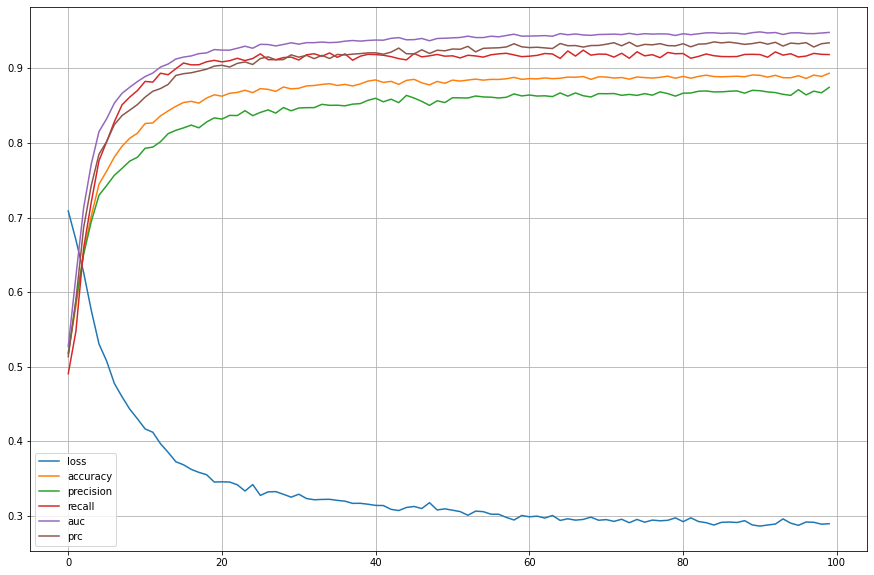

In [149]:
plt.figure(figsize=(15,10))
plt.grid()

for i in to_plot:
    plt.plot(dd[i], label = i)
    plt.grid()
    plt.legend()


In [154]:
dd.iloc[99]

loss                0.289861
tp               5918.000000
fp                851.000000
tn               5603.000000
fn                527.000000
accuracy            0.893170
precision           0.874280
recall              0.918231
auc                 0.947891
prc                 0.933923
val_loss            0.267418
val_tp            667.000000
val_fp             95.000000
val_tn            615.000000
val_fn             57.000000
val_accuracy        0.894003
val_precision       0.875328
val_recall          0.921271
val_auc             0.952057
val_prc             0.923839
Name: 99, dtype: float64

In [139]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [140]:
ypred = Model.predict(xtest)
ypred = np.around(ypred)
cm = confusion_matrix(ytest,ypred)


<AxesSubplot:>

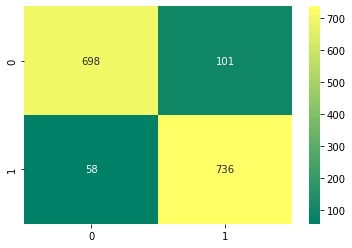

In [141]:
sns.heatmap(cm, annot=True, fmt = 'g',cmap = 'summer')